# Sprint 機械学習スクラッチ 線形回帰

In [1]:
import pandas as pd
import numpy as np

### ＜データ読込＞

In [2]:
df = pd.read_csv('./HousePrices.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [21]:

drop_df = df
# 半分以上欠損値を含む列を削除する。
drop_df = drop_df.dropna(thresh=df.shape[0]*0.5, axis=1)

# 欠損値があるサンプル（行）は削除する。
drop_df = drop_df.dropna(axis=0)

In [22]:
df_data = drop_df.loc[:,["GrLivArea","YearBuilt","SalePrice"]]
df_data

,GrLivArea,YearBuilt,SalePrice
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000
6,1694,2004,307000
...,...,...,...
1447,2090,1995,240000
1451,1578,2008,287090
1455,1647,1999,175000
1456,2073,1978,210000


In [23]:
# ndarrayへ変換
X = np.array(df_data.iloc[:,0:2])
y = np.array(df_data.iloc[:,2])

In [24]:
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [25]:
# 標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
ss_X_train = ss.transform(X_train)
ss_X_val = ss.transform(X_val)


In [8]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, no_bias = True, verbose = True):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        self.theta = 0      
        self.coef_ = self.theta
        
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

        self.train_loss = []
        self.test_loss = []
        self.itercnt = []

        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        val_cnt = 1
        
        y = y.reshape(-1,1)
        
        # 学習データと検証データの比率を出す
        if X_val is not None:
            y_val = y_val.reshape(-1,1)
            val_rate = int( X.shape[0] / X_val.shape[0])
        
        # 学習開始        
        # 初期値設定    
        # バイアスありの場合
        if self.no_bias == False:
            # バイアス項 算出
            baias = np.ones(X.shape[0]).reshape(X.shape[0],1)
            
            # バイアス追加
            X = np.hstack([baias, X])
            
            if X_val is not None:
                baias = np.ones(X_val.shape[0]).reshape(X_val.shape[0],1)
                X_val = np.hstack([baias, X_val])
    
        self.theta = np.random.rand(X.shape[1]).reshape(-1,1)
        self.coef_ = self.theta

        for i in range(self.iter):
            # 推定
            y_pred = self.predict(X)

            # 平均二乗誤差
            self.loss[i] = self.loss_func(y_pred, y)
            self.train_loss.append(self.loss[i])
            self.itercnt.append(i)

            # 最急降下法
            error = y_pred - y
            self.coef_ = self._gradient_descent(X, error)
            
            if self.theta is None:
                print("self.theta is None!!!!")
                
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("〇〇〇学習データ{}回目：loss = {}".format(i+1, self.loss[i]))
              
            # 検証データがセットされた場合
            if X_val is not None:
                
                ## val_rateに等しいときのみ計算を行う
                #if (i > 0) & (i % val_rate == 0):
                
                # 推定
                y_val_pred = self.predict(X_val)

                # 平均二乗誤差
                self.val_loss[i] = self.loss_func(y_val_pred, y_val)
                self.test_loss.append(self.val_loss[i])

                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("★★★検証データ{}回目：loss = {}".format(val_cnt, self.val_loss[i]))

                val_cnt += 1
        
    # 【問題1】仮定関数
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        # 特徴量ベクトル:X
        # パラメータベクトル:乱数生成
        # 特徴量の数:X.shape[1]

        hypothesis = np.dot(X, self.theta)
        
        return hypothesis
    
    
    #【問題3】推定
    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        
        if self.theta is None:
            print("self.theta is None!!!!")
        
        y_pred = self._linear_hypothesis(X)
        
        return y_pred
    


    # 【問題2】最急降下法
    def _gradient_descent(self, X, error):
        """
        最急降下法を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        error : 計算した誤差

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """

        self.theta = self.theta - (self.lr / X.shape[0]) * (np.dot(X.T, error))
        
        return self.theta


    def loss_func(self, y_pred, y):
        
        loss  = MSE(y_pred, y) / 2
        
        return loss
        

## 【問題1】仮定関数

### ⇒ScratchLinearRegressionの_linear_hypothesistに記入

## 【問題2】最急降下法

### ⇒ScratchLinearRegressionの_gradient_descentに記入

## 【問題3】推定

### ⇒ScratchLinearRegressionのpredictに記入


## 【問題4】平均二乗誤差

In [9]:
# 【問題4】平均二乗誤差
def MSE(y_pred, y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    mse = (1 / y_pred.shape[0]) * np.dot((y_pred - y).T, (y_pred - y))

    return mse
    

## 【問題5】目的関数

### ⇒ScratchLinearRegressionのloss_funcに記入

## 【問題6】学習と推定

In [26]:
ScratchLR = ScratchLinearRegression(num_iter = 5000, lr = 0.002, no_bias = False, verbose = True)

# 学習開始
ScratchLR.fit(ss_X_train, y_train, ss_X_val, y_val)

〇〇〇学習データ1回目：loss = 28415808763.786266
★★★検証データ1回目：loss = 30906382932.477364
〇〇〇学習データ2回目：loss = 28308651476.08261
★★★検証データ2回目：loss = 30788897832.76591
〇〇〇学習データ3回目：loss = 28201927977.376663
★★★検証データ3回目：loss = 30671885532.998627
〇〇〇学習データ4回目：loss = 28095636508.532593
★★★検証データ4回目：loss = 30555344118.063877
〇〇〇学習データ5回目：loss = 27989775317.562153
★★★検証データ5回目：loss = 30439271680.64211
〇〇〇学習データ6回目：loss = 27884342659.595573
★★★検証データ6回目：loss = 30323666321.174026
〇〇〇学習データ7回目：loss = 27779336796.852562
★★★検証データ7回目：loss = 30208526147.828938
〇〇〇学習データ8回目：loss = 27674755998.613457
★★★検証データ8回目：loss = 30093849276.473175
〇〇〇学習データ9回目：loss = 27570598541.19045
★★★検証データ9回目：loss = 29979633830.63867
〇〇〇学習データ10回目：loss = 27466862707.899006
★★★検証データ10回目：loss = 29865877941.491684
〇〇〇学習データ11回目：loss = 27363546789.029285
★★★検証データ11回目：loss = 29752579747.801598
〇〇〇学習データ12回目：loss = 27260649081.817802
★★★検証データ12回目：loss = 29639737395.90993
〇〇〇学習データ13回目：loss = 27158167890.419113
★★★検証データ13回目：loss = 29527349039.699368
〇〇〇学習データ14

★★★検証データ296回目：loss = 10573440615.458069
〇〇〇学習データ297回目：loss = 9907066168.302147
★★★検証データ297回目：loss = 10537496281.133036
〇〇〇学習データ298回目：loss = 9874773760.942263
★★★検証データ298回目：loss = 10501695237.051285
〇〇〇学習データ299回目：loss = 9842611817.70713
★★★検証データ299回目：loss = 10466036906.435429
〇〇〇学習データ300回目：loss = 9810579810.687634
★★★検証データ300回目：loss = 10430520714.844091
〇〇〇学習データ301回目：loss = 9778677214.11444
★★★検証データ301回目：loss = 10395146090.162422
〇〇〇学習データ302回目：loss = 9746903504.349325
★★★検証データ302回目：loss = 10359912462.592619
〇〇〇学習データ303回目：loss = 9715258159.876501
★★★検証データ303回目：loss = 10324819264.644516
〇〇〇学習データ304回目：loss = 9683740661.294016
★★★検証データ304回目：loss = 10289865931.126183
〇〇〇学習データ305回目：loss = 9652350491.305162
★★★検証データ305回目：loss = 10255051899.134594
〇〇〇学習データ306回目：loss = 9621087134.709925
★★★検証データ306回目：loss = 10220376608.046307
〇〇〇学習データ307回目：loss = 9589950078.39647
★★★検証データ307回目：loss = 10185839499.508194
〇〇〇学習データ308回目：loss = 9558938811.332663
★★★検証データ308回目：loss = 10151440017.428213
〇〇〇学習データ309回目：l

〇〇〇学習データ642回目：loss = 3889734978.70681
★★★検証データ642回目：loss = 3804615881.3005915
〇〇〇学習データ643回目：loss = 3881733449.562216
★★★検証データ643回目：loss = 3795492023.757267
〇〇〇学習データ644回目：loss = 3873764181.521834
★★★検証データ644回目：loss = 3786403907.845083
〇〇〇学習データ645回目：loss = 3865827044.336657
★★★検証データ645回目：loss = 3777351391.253972
〇〇〇学習データ646回目：loss = 3857921908.2843194
★★★検証データ646回目：loss = 3768334332.2460938
〇〇〇学習データ647回目：loss = 3850048644.1669655
★★★検証データ647回目：loss = 3759352589.6535115
〇〇〇学習データ648回目：loss = 3842207123.309124
★★★検証データ648回目：loss = 3750406022.875904
〇〇〇学習データ649回目：loss = 3834397217.555596
★★★検証データ649回目：loss = 3741494491.878252
〇〇〇学習データ650回目：loss = 3826618799.2693424
★★★検証データ650回目：loss = 3732617857.188564
〇〇〇学習データ651回目：loss = 3818871741.3293915
★★★検証データ651回目：loss = 3723775979.895587
〇〇〇学習データ652回目：loss = 3811155917.128744
★★★検証データ652回目：loss = 3714968721.6465487
〇〇〇学習データ653回目：loss = 3803471200.5722957
★★★検証データ653回目：loss = 3706195944.6448855
〇〇〇学習データ654回目：loss = 3795817466.0747595
★★★検証データ654回目：l

〇〇〇学習データ1088回目：loss = 2231909541.6685753
★★★検証データ1088回目：loss = 1868671438.9733064
〇〇〇学習データ1089回目：loss = 2230586591.1579657
★★★検証データ1089回目：loss = 1867036536.6902838
〇〇〇学習データ1090回目：loss = 2229268962.651445
★★★検証データ1090回目：loss = 1865407784.5617883
〇〇〇学習データ1091回目：loss = 2227956634.715095
★★★検証データ1091回目：loss = 1863785158.7003376
〇〇〇学習データ1092回目：loss = 2226649586.001432
★★★検証データ1092回目：loss = 1862168635.3130372
〇〇〇学習データ1093回目：loss = 2225347795.249049
★★★検証データ1093回目：loss = 1860558190.7012026
〇〇〇学習データ1094回目：loss = 2224051241.2822776
★★★検証データ1094回目：loss = 1858953801.2599843
〇〇〇学習データ1095回目：loss = 2222759903.0108337
★★★検証データ1095回目：loss = 1857355443.477985
〇〇〇学習データ1096回目：loss = 2221473759.42948
★★★検証データ1096回目：loss = 1855763093.9368935
〇〇〇学習データ1097回目：loss = 2220192789.617676
★★★検証データ1097回目：loss = 1854176729.3111064
〇〇〇学習データ1098回目：loss = 2218916972.73924
★★★検証データ1098回目：loss = 1852596326.3673592
〇〇〇学習データ1099回目：loss = 2217646288.042009
★★★検証データ1099回目：loss = 1851021861.9643545
〇〇〇学習データ1100回目：loss = 22163

★★★検証データ1558回目：loss = 1503745329.631997
〇〇〇学習データ1559回目：loss = 1952199920.3418014
★★★検証データ1559回目：loss = 1503449619.6266532
〇〇〇学習データ1560回目：loss = 1952001380.768348
★★★検証データ1560回目：loss = 1503154938.2223506
〇〇〇学習データ1561回目：loss = 1951803638.2963178
★★★検証データ1561回目：loss = 1502861281.6220098
〇〇〇学習データ1562回目：loss = 1951606689.7223992
★★★検証データ1562回目：loss = 1502568646.0431216
〇〇〇学習データ1563回目：loss = 1951410531.8561687
★★★検証データ1563回目：loss = 1502277027.7176902
〇〇〇学習データ1564回目：loss = 1951215161.5200362
★★★検証データ1564回目：loss = 1501986422.892176
〇〇〇学習データ1565回目：loss = 1951020575.5491955
★★★検証データ1565回目：loss = 1501696827.8274386
〇〇〇学習データ1566回目：loss = 1950826770.7915716
★★★検証データ1566回目：loss = 1501408238.7986808
〇〇〇学習データ1567回目：loss = 1950633744.1077688
★★★検証データ1567回目：loss = 1501120652.0953937
〇〇〇学習データ1568回目：loss = 1950441492.3710225
★★★検証データ1568回目：loss = 1500834064.0212958
〇〇〇学習データ1569回目：loss = 1950250012.4671438
★★★検証データ1569回目：loss = 1500548470.894282
〇〇〇学習データ1570回目：loss = 1950059301.2944744
★★★検証データ1570回目：loss 

★★★検証データ1906回目：loss = 1443336125.8419206
〇〇〇学習データ1907回目：loss = 1914935564.6911452
★★★検証データ1907回目：loss = 1443243811.2805572
〇〇〇学習データ1908回目：loss = 1914886559.2852736
★★★検証データ1908回目：loss = 1443151791.4143593
〇〇〇学習データ1909回目：loss = 1914837750.3750765
★★★検証データ1909回目：loss = 1443060065.2216716
〇〇〇学習データ1910回目：loss = 1914789137.1719847
★★★検証データ1910回目：loss = 1442968631.6846
〇〇〇学習データ1911回目：loss = 1914740718.8905966
★★★検証データ1911回目：loss = 1442877489.7889977
〇〇〇学習データ1912回目：loss = 1914692494.7486649
★★★検証データ1912回目：loss = 1442786638.5244486
〇〇〇学習データ1913回目：loss = 1914644463.9670846
★★★検証データ1913回目：loss = 1442696076.8842583
〇〇〇学習データ1914回目：loss = 1914596625.769881
★★★検証データ1914回目：loss = 1442605803.865434
〇〇〇学習データ1915回目：loss = 1914548979.3841953
★★★検証データ1915回目：loss = 1442515818.4686744
〇〇〇学習データ1916回目：loss = 1914501524.040274
★★★検証データ1916回目：loss = 1442426119.6983533
〇〇〇学習データ1917回目：loss = 1914454258.971455
★★★検証データ1917回目：loss = 1442336706.5625067
〇〇〇学習データ1918回目：loss = 1914407183.4141562
★★★検証データ1918回目：loss = 1

〇〇〇学習データ2287回目：loss = 1905366819.563024
★★★検証データ2287回目：loss = 1422655493.3149045
〇〇〇学習データ2288回目：loss = 1905356162.9980767
★★★検証データ2288回目：loss = 1422626380.0647485
〇〇〇学習データ2289回目：loss = 1905345549.1081476
★★★検証データ2289回目：loss = 1422597350.0161767
〇〇〇学習データ2290回目：loss = 1905334977.722205
★★★検証データ2290回目：loss = 1422568402.906983
〇〇〇学習データ2291回目：loss = 1905324448.6699028
★★★検証データ2291回目：loss = 1422539538.4758594
〇〇〇学習データ2292回目：loss = 1905313961.7815785
★★★検証データ2292回目：loss = 1422510756.4623952
〇〇〇学習データ2293回目：loss = 1905303516.88825
★★★検証データ2293回目：loss = 1422482056.6070724
〇〇〇学習データ2294回目：loss = 1905293113.8216133
★★★検証データ2294回目：loss = 1422453438.6512613
〇〇〇学習データ2295回目：loss = 1905282752.4140387
★★★検証データ2295回目：loss = 1422424902.3372202
〇〇〇学習データ2296回目：loss = 1905272432.4985704
★★★検証データ2296回目：loss = 1422396447.4080899
〇〇〇学習データ2297回目：loss = 1905262153.9089198
★★★検証データ2297回目：loss = 1422368073.6078901
〇〇〇学習データ2298回目：loss = 1905251916.4794683
★★★検証データ2298回目：loss = 1422339780.6815188
〇〇〇学習データ2299回目：loss =

〇〇〇学習データ2722回目：loss = 1903169712.079006
★★★検証データ2722回目：loss = 1415270646.5832083
〇〇〇学習データ2723回目：loss = 1903167849.6536024
★★★検証データ2723回目：loss = 1415261625.4460123
〇〇〇学習データ2724回目：loss = 1903165994.6763382
★★★検証データ2724回目：loss = 1415252627.2039678
〇〇〇学習データ2725回目：loss = 1903164147.1174037
★★★検証データ2725回目：loss = 1415243651.7934775
〇〇〇学習データ2726回目：loss = 1903162306.9471107
★★★検証データ2726回目：loss = 1415234699.1511369
〇〇〇学習データ2727回目：loss = 1903160474.1358883
★★★検証データ2727回目：loss = 1415225769.2137363
〇〇〇学習データ2728回目：loss = 1903158648.654284
★★★検証データ2728回目：loss = 1415216861.9182606
〇〇〇学習データ2729回目：loss = 1903156830.472964
★★★検証データ2729回目：loss = 1415207977.2018864
〇〇〇学習データ2730回目：loss = 1903155019.5627117
★★★検証データ2730回目：loss = 1415199115.0019825
〇〇〇学習データ2731回目：loss = 1903153215.894428
★★★検証データ2731回目：loss = 1415190275.25611
〇〇〇学習データ2732回目：loss = 1903151419.4391286
★★★検証データ2732回目：loss = 1415181457.90202
〇〇〇学習データ2733回目：loss = 1903149630.1679475
★★★検証データ2733回目：loss = 1415172662.8776546
〇〇〇学習データ2734回目：loss = 19

〇〇〇学習データ3177回目：loss = 1902779121.8409348
★★★検証データ3177回目：loss = 1412800885.8387787
〇〇〇学習データ3178回目：loss = 1902778820.6877275
★★★検証データ3178回目：loss = 1412797890.2252624
〇〇〇学習データ3179回目：loss = 1902778520.7372286
★★★検証データ3179回目：loss = 1412794901.564936
〇〇〇学習データ3180回目：loss = 1902778221.9846318
★★★検証データ3180回目：loss = 1412791919.8406036
〇〇〇学習データ3181回目：loss = 1902777924.4251494
★★★検証データ3181回目：loss = 1412788945.0351148
〇〇〇学習データ3182回目：loss = 1902777628.054013
★★★検証データ3182回目：loss = 1412785977.1313667
〇〇〇学習データ3183回目：loss = 1902777332.8664725
★★★検証データ3183回目：loss = 1412783016.1123016
〇〇〇学習データ3184回目：loss = 1902777038.8577979
★★★検証データ3184回目：loss = 1412780061.9609072
〇〇〇学習データ3185回目：loss = 1902776746.0232782
★★★検証データ3185回目：loss = 1412777114.6602178
〇〇〇学習データ3186回目：loss = 1902776454.3582206
★★★検証データ3186回目：loss = 1412774174.1933126
〇〇〇学習データ3187回目：loss = 1902776163.8579507
★★★検証データ3187回目：loss = 1412771240.5433166
〇〇〇学習データ3188回目：loss = 1902775874.5178134
★★★検証データ3188回目：loss = 1412768313.6933994
〇〇〇学習データ3189回目：los

〇〇〇学習データ3629回目：loss = 1902716054.9226441
★★★検証データ3629回目：loss = 1411955125.954225
〇〇〇学習データ3630回目：loss = 1902716005.5144837
★★★検証データ3630回目：loss = 1411954046.4471211
〇〇〇学習データ3631回目：loss = 1902715956.3033679
★★★検証データ3631回目：loss = 1411952969.3170922
〇〇〇学習データ3632回目：loss = 1902715907.2885094
★★★検証データ3632回目：loss = 1411951894.5586994
〇〇〇学習データ3633回目：loss = 1902715858.4691257
★★★検証データ3633回目：loss = 1411950822.1665182
〇〇〇学習データ3634回目：loss = 1902715809.844437
★★★検証データ3634回目：loss = 1411949752.1351366
〇〇〇学習データ3635回目：loss = 1902715761.413665
★★★検証データ3635回目：loss = 1411948684.4591558
〇〇〇学習データ3636回目：loss = 1902715713.1760366
★★★検証データ3636回目：loss = 1411947619.13319
〇〇〇学習データ3637回目：loss = 1902715665.1307807
★★★検証データ3637回目：loss = 1411946556.1518662
〇〇〇学習データ3638回目：loss = 1902715617.2771294
★★★検証データ3638回目：loss = 1411945495.5098252
〇〇〇学習データ3639回目：loss = 1902715569.6143184
★★★検証データ3639回目：loss = 1411944437.2017195
〇〇〇学習データ3640回目：loss = 1902715522.1415854
★★★検証データ3640回目：loss = 1411943381.2222154
〇〇〇学習データ3641回目：loss =

〇〇〇学習データ4012回目：loss = 1902706345.3350666
★★★検証データ4012回目：loss = 1411674708.0295572
〇〇〇学習データ4013回目：loss = 1902706334.6314504
★★★検証データ4013回目：loss = 1411674238.500206
〇〇〇学習データ4014回目：loss = 1902706323.9704673
★★★検証データ4014回目：loss = 1411673769.9781363
〇〇〇学習データ4015回目：loss = 1902706313.3519466
★★★検証データ4015回目：loss = 1411673302.4611335
〇〇〇学習データ4016回目：loss = 1902706302.7757196
★★★検証データ4016回目：loss = 1411672835.9469883
〇〇〇学習データ4017回目：loss = 1902706292.2416172
★★★検証データ4017回目：loss = 1411672370.433497
〇〇〇学習データ4018回目：loss = 1902706281.7494714
★★★検証データ4018回目：loss = 1411671905.9184587
〇〇〇学習データ4019回目：loss = 1902706271.299116
★★★検証データ4019回目：loss = 1411671442.3996804
〇〇〇学習データ4020回目：loss = 1902706260.8903835
★★★検証データ4020回目：loss = 1411670979.8749714
〇〇〇学習データ4021回目：loss = 1902706250.523108
★★★検証データ4021回目：loss = 1411670518.3421483
〇〇〇学習データ4022回目：loss = 1902706240.1971242
★★★検証データ4022回目：loss = 1411670057.7990317
〇〇〇学習データ4023回目：loss = 1902706229.9122677
★★★検証データ4023回目：loss = 1411669598.2434466
〇〇〇学習データ4024回目：loss 

★★★検証データ4408回目：loss = 1411549080.342935
〇〇〇学習データ4409回目：loss = 1902704208.5944176
★★★検証データ4409回目：loss = 1411548878.19026
〇〇〇学習データ4410回目：loss = 1902704206.3969553
★★★検証データ4410回目：loss = 1411548676.4638817
〇〇〇学習データ4411回目：loss = 1902704204.2082329
★★★検証データ4411回目：loss = 1411548475.1628866
〇〇〇学習データ4412回目：loss = 1902704202.0282152
★★★検証データ4412回目：loss = 1411548274.2863622
〇〇〇学習データ4413回目：loss = 1902704199.8568683
★★★検証データ4413回目：loss = 1411548073.8333993
〇〇〇学習データ4414回目：loss = 1902704197.694156
★★★検証データ4414回目：loss = 1411547873.8030884
〇〇〇学習データ4415回目：loss = 1902704195.5400462
★★★検証データ4415回目：loss = 1411547674.194525
〇〇〇学習データ4416回目：loss = 1902704193.3945034
★★★検証データ4416回目：loss = 1411547475.006804
〇〇〇学習データ4417回目：loss = 1902704191.257493
★★★検証データ4417回目：loss = 1411547276.2390242
〇〇〇学習データ4418回目：loss = 1902704189.128982
★★★検証データ4418回目：loss = 1411547077.8902845
〇〇〇学習データ4419回目：loss = 1902704187.0089362
★★★検証データ4419回目：loss = 1411546879.9596875
〇〇〇学習データ4420回目：loss = 1902704184.897322
★★★検証データ4420回目：loss = 141

★★★検証データ4723回目：loss = 1411502474.2351718
〇〇〇学習データ4724回目：loss = 1902703813.46416
★★★検証データ4724回目：loss = 1411502369.9171805
〇〇〇学習データ4725回目：loss = 1902703812.8374076
★★★検証データ4725回目：loss = 1411502265.8170154
〇〇〇学習データ4726回目：loss = 1902703812.2131448
★★★検証データ4726回目：loss = 1411502161.9342148
〇〇〇学習データ4727回目：loss = 1902703811.591361
★★★検証データ4727回目：loss = 1411502058.2683191
〇〇〇学習データ4728回目：loss = 1902703810.9720478
★★★検証データ4728回目：loss = 1411501954.81887
〇〇〇学習データ4729回目：loss = 1902703810.3551939
★★★検証データ4729回目：loss = 1411501851.5854087
〇〇〇学習データ4730回目：loss = 1902703809.7407897
★★★検証データ4730回目：loss = 1411501748.567479
〇〇〇学習データ4731回目：loss = 1902703809.1288266
★★★検証データ4731回目：loss = 1411501645.7646232
〇〇〇学習データ4732回目：loss = 1902703808.5192935
★★★検証データ4732回目：loss = 1411501543.1763885
〇〇〇学習データ4733回目：loss = 1902703807.9121816
★★★検証データ4733回目：loss = 1411501440.8023198
〇〇〇学習データ4734回目：loss = 1902703807.3074815
★★★検証データ4734回目：loss = 1411501338.641964
〇〇〇学習データ4735回目：loss = 1902703806.7051826
★★★検証データ4735回目：loss = 1

## 【問題7】学習曲線のプロット

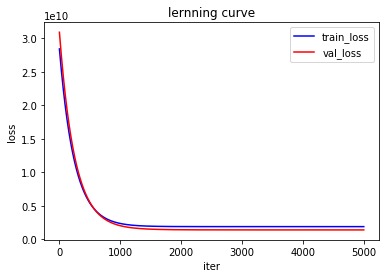

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(ScratchLR.loss)), ScratchLR.loss, color='blue', label='train_loss')
plt.plot(range(len(ScratchLR.val_loss)), ScratchLR.val_loss, color='red', label='val_loss')
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("lernning curve")
plt.legend()
plt.show()

検証データで、iter = 1500以降はloss = 0.3e+10で収束しており、それ以上学習は進まない。

## 【問題8】（アドバンス課題）バイアス項の除去

In [28]:
# バイアス無しで実施する。
ScratchLR_noBias = ScratchLinearRegression(num_iter = 5000, lr = 0.002, no_bias = True, verbose = True)

ScratchLR_noBias.fit(ss_X_train, y_train, ss_X_val, y_val)

〇〇〇学習データ1回目：loss = 28415821812.7729
★★★検証データ1回目：loss = 31008028698.232983
〇〇〇学習データ2回目：loss = 28405259348.972767
★★★検証データ2回目：loss = 30991773466.069187
〇〇〇学習データ3回目：loss = 28394744681.217594
★★★検証データ3回目：loss = 30975576082.090202
〇〇〇学習データ4回目：loss = 28384277592.79955
★★★検証データ4回目：loss = 30959436319.80067
〇〇〇学習データ5回目：loss = 28373857867.994827
★★★検証データ5回目：loss = 30943353953.65344
〇〇〇学習データ6回目：loss = 28363485292.059208
★★★検証データ6回目：loss = 30927328759.045456
〇〇〇学習データ7回目：loss = 28353159651.223537
★★★検証データ7回目：loss = 30911360512.313602
〇〇〇学習データ8回目：loss = 28342880732.68937
★★★検証データ8回目：loss = 30895448990.73062
〇〇〇学習データ9回目：loss = 28332648324.62448
★★★検証データ9回目：loss = 30879593972.50104
〇〇〇学習データ10回目：loss = 28322462216.158546
★★★検証データ10回目：loss = 30863795236.757103
〇〇〇学習データ11回目：loss = 28312322197.378727
★★★検証データ11回目：loss = 30848052563.554726
〇〇〇学習データ12回目：loss = 28302228059.325317
★★★検証データ12回目：loss = 30832365733.869473
〇〇〇学習データ13回目：loss = 28292179593.987415
★★★検証データ13回目：loss = 30816734529.592552
〇〇〇学習データ14回目：

★★★検証データ364回目：loss = 27626396626.480206
〇〇〇学習データ365回目：loss = 26528361635.96157
★★★検証データ365回目：loss = 27621550621.453648
〇〇〇学習データ366回目：loss = 26526328643.64607
★★★検証データ366回目：loss = 27616719656.759636
〇〇〇学習データ367回目：loss = 26524304814.229904
★★★検証データ367回目：loss = 27611903680.089573
〇〇〇学習データ368回目：loss = 26522290106.294796
★★★検証データ368回目：loss = 27607102639.3361
〇〇〇学習データ369回目：loss = 26520284478.610134
★★★検証データ369回目：loss = 27602316482.592247
〇〇〇学習データ370回目：loss = 26518287890.13206
★★★検証データ370回目：loss = 27597545158.150608
〇〇〇学習データ371回目：loss = 26516300300.00269
★★★検証データ371回目：loss = 27592788614.502506
〇〇〇学習データ372回目：loss = 26514321667.5492
★★★検証データ372回目：loss = 27588046800.337196
〇〇〇学習データ373回目：loss = 26512351952.28304
★★★検証データ373回目：loss = 27583319664.54102
〇〇〇学習データ374回目：loss = 26510391113.899063
★★★検証データ374回目：loss = 27578607156.19661
〇〇〇学習データ375回目：loss = 26508439112.274723
★★★検証データ375回目：loss = 27573909224.582058
〇〇〇学習データ376回目：loss = 26506495907.46922
★★★検証データ376回目：loss = 27569225819.170124
〇〇〇学習データ377回

〇〇〇学習データ751回目：loss = 26155813904.206493
★★★検証データ751回目：loss = 26512412514.597916
〇〇〇学習データ752回目：loss = 26155456574.68665
★★★検証データ752回目：loss = 26510839390.249107
〇〇〇学習データ753回目：loss = 26155100845.678963
★★★検証データ753回目：loss = 26509270557.765415
〇〇〇学習データ754回目：loss = 26154746709.983536
★★★検証データ754回目：loss = 26507706004.253513
〇〇〇学習データ755回目：loss = 26154394160.43294
★★★検証データ755回目：loss = 26506145716.86347
〇〇〇学習データ756回目：loss = 26154043189.892117
★★★検証データ756回目：loss = 26504589682.788578
〇〇〇学習データ757回目：loss = 26153693791.258198
★★★検証データ757回目：loss = 26503037889.26522
〇〇〇学習データ758回目：loss = 26153345957.46038
★★★検証データ758回目：loss = 26501490323.572693
〇〇〇学習データ759回目：loss = 26152999681.45977
★★★検証データ759回目：loss = 26499946973.033012
〇〇〇学習データ760回目：loss = 26152654956.24926
★★★検証データ760回目：loss = 26498407825.010822
〇〇〇学習データ761回目：loss = 26152311774.853333
★★★検証データ761回目：loss = 26496872866.91315
〇〇〇学習データ762回目：loss = 26151970130.327984
★★★検証データ762回目：loss = 26495342086.18935
〇〇〇学習データ763回目：loss = 26151630015.76053
★★★検証データ76

★★★検証データ1213回目：loss = 26092273153.990242
〇〇〇学習データ1214回目：loss = 26085886976.88653
★★★検証データ1214回目：loss = 26091798687.73418
〇〇〇学習データ1215回目：loss = 26085841777.090496
★★★検証データ1215回目：loss = 26091325401.273205
〇〇〇学習データ1216回目：loss = 26085796777.460083
★★★検証データ1216回目：loss = 26090853291.51947
〇〇〇学習データ1217回目：loss = 26085751977.102844
★★★検証データ1217回目：loss = 26090382355.393913
〇〇〇学習データ1218回目：loss = 26085707375.13033
★★★検証データ1218回目：loss = 26089912589.82621
〇〇〇学習データ1219回目：loss = 26085662970.658066
★★★検証データ1219回目：loss = 26089443991.75475
〇〇〇学習データ1220回目：loss = 26085618762.805553
★★★検証データ1220回目：loss = 26088976558.12661
〇〇〇学習データ1221回目：loss = 26085574750.696228
★★★検証データ1221回目：loss = 26088510285.89752
〇〇〇学習データ1222回目：loss = 26085530933.45746
★★★検証データ1222回目：loss = 26088045172.031845
〇〇〇学習データ1223回目：loss = 26085487310.220543
★★★検証データ1223回目：loss = 26087581213.502552
〇〇〇学習データ1224回目：loss = 26085443880.12064
★★★検証データ1224回目：loss = 26087118407.29119
〇〇〇学習データ1225回目：loss = 26085400642.2968
★★★検証データ1225回目：loss = 2608665

〇〇〇学習データ1624回目：loss = 26077313954.96602
★★★検証データ1624回目：loss = 25969347425.494556
〇〇〇学習データ1625回目：loss = 26077306535.767467
★★★検証データ1625回目：loss = 25969173310.97464
〇〇〇学習データ1626回目：loss = 26077299148.939827
★★★検証データ1626回目：loss = 25968999614.221443
〇〇〇学習データ1627回目：loss = 26077291794.340504
★★★検証データ1627回目：loss = 25968826334.211384
〇〇〇学習データ1628回目：loss = 26077284471.82749
★★★検証データ1628回目：loss = 25968653469.923477
〇〇〇学習データ1629回目：loss = 26077277181.259457
★★★検証データ1629回目：loss = 25968481020.339367
〇〇〇学習データ1630回目：loss = 26077269922.49567
★★★検証データ1630回目：loss = 25968308984.443283
〇〇〇学習データ1631回目：loss = 26077262695.396023
★★★検証データ1631回目：loss = 25968137361.222065
〇〇〇学習データ1632回目：loss = 26077255499.821056
★★★検証データ1632回目：loss = 25967966149.66513
〇〇〇学習データ1633回目：loss = 26077248335.631897
★★★検証データ1633回目：loss = 25967795348.764465
〇〇〇学習データ1634回目：loss = 26077241202.690308
★★★検証データ1634回目：loss = 25967624957.51466
〇〇〇学習データ1635回目：loss = 26077234100.85867
★★★検証データ1635回目：loss = 25967454974.912846
〇〇〇学習データ1636回目：loss = 2

★★★検証データ2053回目：loss = 25922572765.429596
〇〇〇学習データ2054回目：loss = 26075867759.854763
★★★検証データ2054回目：loss = 25922510167.770412
〇〇〇学習データ2055回目：loss = 26075866606.207104
★★★検証データ2055回目：loss = 25922447718.53627
〇〇〇学習データ2056回目：loss = 26075865457.485653
★★★検証データ2056回目：loss = 25922385417.373837
〇〇〇学習データ2057回目：loss = 26075864313.669086
★★★検証データ2057回目：loss = 25922323263.930653
〇〇〇学習データ2058回目：loss = 26075863174.73618
★★★検証データ2058回目：loss = 25922261257.85509
〇〇〇学習データ2059回目：loss = 26075862040.665806
★★★検証データ2059回目：loss = 25922199398.796387
〇〇〇学習データ2060回目：loss = 26075860911.436924
★★★検証データ2060回目：loss = 25922137686.404613
〇〇〇学習データ2061回目：loss = 26075859787.028587
★★★検証データ2061回目：loss = 25922076120.330704
〇〇〇学習データ2062回目：loss = 26075858667.419926
★★★検証データ2062回目：loss = 25922014700.226414
〇〇〇学習データ2063回目：loss = 26075857552.5902
★★★検証データ2063回目：loss = 25921953425.744358
〇〇〇学習データ2064回目：loss = 26075856442.518707
★★★検証データ2064回目：loss = 25921892296.537983
〇〇〇学習データ2065回目：loss = 26075855337.18489
★★★検証データ2065回目：loss = 

〇〇〇学習データ2446回目：loss = 26075647170.680214
★★★検証データ2446回目：loss = 25906555100.055984
〇〇〇学習データ2447回目：loss = 26075646950.716606
★★★検証データ2447回目：loss = 25906530465.276787
〇〇〇学習データ2448回目：loss = 26075646731.668884
★★★検証データ2448回目：loss = 25906505888.935436
〇〇〇学習データ2449回目：loss = 26075646513.533203
★★★検証データ2449回目：loss = 25906481370.893894
〇〇〇学習データ2450回目：loss = 26075646296.305683
★★★検証データ2450回目：loss = 25906456911.014446
〇〇〇学習データ2451回目：loss = 26075646079.98248
★★★検証データ2451回目：loss = 25906432509.159702
〇〇〇学習データ2452回目：loss = 26075645864.55977
★★★検証データ2452回目：loss = 25906408165.1926
〇〇〇学習データ2453回目：loss = 26075645650.033733
★★★検証データ2453回目：loss = 25906383878.976402
〇〇〇学習データ2454回目：loss = 26075645436.400593
★★★検証データ2454回目：loss = 25906359650.37469
〇〇〇学習データ2455回目：loss = 26075645223.656544
★★★検証データ2455回目：loss = 25906335479.25138
〇〇〇学習データ2456回目：loss = 26075645011.79784
★★★検証データ2456回目：loss = 25906311365.470695
〇〇〇学習データ2457回目：loss = 26075644800.820732
★★★検証データ2457回目：loss = 25906287308.89719
〇〇〇学習データ2458回目：loss = 26

〇〇〇学習データ2873回目：loss = 26075602994.920578
★★★検証データ2873回目：loss = 25899941899.838806
〇〇〇学習データ2874回目：loss = 26075602956.842777
★★★検証データ2874回目：loss = 25899932993.142803
〇〇〇学習データ2875回目：loss = 26075602918.918488
★★★検証データ2875回目：loss = 25899924107.73117
〇〇〇学習データ2876回目：loss = 26075602881.14709
★★★検証データ2876回目：loss = 25899915243.553555
〇〇〇学習データ2877回目：loss = 26075602843.52795
★★★検証データ2877回目：loss = 25899906400.559723
〇〇〇学習データ2878回目：loss = 26075602806.060444
★★★検証データ2878回目：loss = 25899897578.69956
〇〇〇学習データ2879回目：loss = 26075602768.743942
★★★検証データ2879回目：loss = 25899888777.92306
〇〇〇学習データ2880回目：loss = 26075602731.577835
★★★検証データ2880回目：loss = 25899879998.18035
〇〇〇学習データ2881回目：loss = 26075602694.561493
★★★検証データ2881回目：loss = 25899871239.42166
〇〇〇学習データ2882回目：loss = 26075602657.694313
★★★検証データ2882回目：loss = 25899862501.597343
〇〇〇学習データ2883回目：loss = 26075602620.97567
★★★検証データ2883回目：loss = 25899853784.657875
〇〇〇学習データ2884回目：loss = 26075602584.404957
★★★検証データ2884回目：loss = 25899845088.553833
〇〇〇学習データ2885回目：loss = 26

★★★検証データ3250回目：loss = 25897729706.313416
〇〇〇学習データ3251回目：loss = 26075595564.58869
★★★検証データ3251回目：loss = 25897726109.42255
〇〇〇学習データ3252回目：loss = 26075595556.127163
★★★検証データ3252回目：loss = 25897722521.224197
〇〇〇学習データ3253回目：loss = 26075595547.698734
★★★検証データ3253回目：loss = 25897718941.69766
〇〇〇学習データ3254回目：loss = 26075595539.303257
★★★検証データ3254回目：loss = 25897715370.822285
〇〇〇学習データ3255回目：loss = 26075595530.940617
★★★検証データ3255回目：loss = 25897711808.577477
〇〇〇学習データ3256回目：loss = 26075595522.61067
★★★検証データ3256回目：loss = 25897708254.942684
〇〇〇学習データ3257回目：loss = 26075595514.313286
★★★検証データ3257回目：loss = 25897704709.89741
〇〇〇学習データ3258回目：loss = 26075595506.04834
★★★検証データ3258回目：loss = 25897701173.4212
〇〇〇学習データ3259回目：loss = 26075595497.8157
★★★検証データ3259回目：loss = 25897697645.49364
〇〇〇学習データ3260回目：loss = 26075595489.61524
★★★検証データ3260回目：loss = 25897694126.094383
〇〇〇学習データ3261回目：loss = 26075595481.446823
★★★検証データ3261回目：loss = 25897690615.203117
〇〇〇学習データ3262回目：loss = 26075595473.310337
★★★検証データ3262回目：loss = 258976

〇〇〇学習データ3655回目：loss = 26075593836.01018
★★★検証データ3655回目：loss = 25896801816.81037
〇〇〇学習データ3656回目：loss = 26075593834.228806
★★★検証データ3656回目：loss = 25896800477.68782
〇〇〇学習データ3657回目：loss = 26075593832.454185
★★★検証データ3657回目：loss = 25896799141.85889
〇〇〇学習データ3658回目：loss = 26075593830.686283
★★★検証データ3658回目：loss = 25896797809.31565
〇〇〇学習データ3659回目：loss = 26075593828.925083
★★★検証データ3659回目：loss = 25896796480.05019
〇〇〇学習データ3660回目：loss = 26075593827.170563
★★★検証データ3660回目：loss = 25896795154.05462
〇〇〇学習データ3661回目：loss = 26075593825.42268
★★★検証データ3661回目：loss = 25896793831.321053
〇〇〇学習データ3662回目：loss = 26075593823.68143
★★★検証データ3662回目：loss = 25896792511.841656
〇〇〇学習データ3663回目：loss = 26075593821.94677
★★★検証データ3663回目：loss = 25896791195.608574
〇〇〇学習データ3664回目：loss = 26075593820.218678
★★★検証データ3664回目：loss = 25896789882.613995
〇〇〇学習データ3665回目：loss = 26075593818.49714
★★★検証データ3665回目：loss = 25896788572.850124
〇〇〇学習データ3666回目：loss = 26075593816.782112
★★★検証データ3666回目：loss = 25896787266.309177
〇〇〇学習データ3667回目：loss = 26075

〇〇〇学習データ4133回目：loss = 26075593440.146046
★★★検証データ4133回目：loss = 25896426612.638702
〇〇〇学習データ4134回目：loss = 26075593439.847263
★★★検証データ4134回目：loss = 25896426206.99494
〇〇〇学習データ4135回目：loss = 26075593439.549576
★★★検証データ4135回目：loss = 25896425802.380592
〇〇〇学習データ4136回目：loss = 26075593439.252987
★★★検証データ4136回目：loss = 25896425398.793144
〇〇〇学習データ4137回目：loss = 26075593438.95748
★★★検証データ4137回目：loss = 25896424996.230064
〇〇〇学習データ4138回目：loss = 26075593438.663063
★★★検証データ4138回目：loss = 25896424594.68884
〇〇〇学習データ4139回目：loss = 26075593438.369724
★★★検証データ4139回目：loss = 25896424194.166958
〇〇〇学習データ4140回目：loss = 26075593438.077465
★★★検証データ4140回目：loss = 25896423794.661915
〇〇〇学習データ4141回目：loss = 26075593437.786274
★★★検証データ4141回目：loss = 25896423396.17122
〇〇〇学習データ4142回目：loss = 26075593437.496155
★★★検証データ4142回目：loss = 25896422998.692364
〇〇〇学習データ4143回目：loss = 26075593437.2071
★★★検証データ4143回目：loss = 25896422602.22288
〇〇〇学習データ4144回目：loss = 26075593436.919106
★★★検証データ4144回目：loss = 25896422206.76028
〇〇〇学習データ4145回目：loss = 26

〇〇〇学習データ4512回目：loss = 26075593378.750496
★★★検証データ4512回目：loss = 25896328201.918407
〇〇〇学習データ4513回目：loss = 26075593378.67531
★★★検証データ4513回目：loss = 25896328049.72358
〇〇〇学習データ4514回目：loss = 26075593378.60039
★★★検証データ4514回目：loss = 25896327897.929974
〇〇〇学習データ4515回目：loss = 26075593378.525745
★★★検証データ4515回目：loss = 25896327746.53659
〇〇〇学習データ4516回目：loss = 26075593378.451355
★★★検証データ4516回目：loss = 25896327595.54242
〇〇〇学習データ4517回目：loss = 26075593378.377247
★★★検証データ4517回目：loss = 25896327444.946465
〇〇〇学習データ4518回目：loss = 26075593378.303402
★★★検証データ4518回目：loss = 25896327294.74772
〇〇〇学習データ4519回目：loss = 26075593378.229824
★★★検証データ4519回目：loss = 25896327144.94518
〇〇〇学習データ4520回目：loss = 26075593378.15651
★★★検証データ4520回目：loss = 25896326995.53786
〇〇〇学習データ4521回目：loss = 26075593378.08346
★★★検証データ4521回目：loss = 25896326846.52476
〇〇〇学習データ4522回目：loss = 26075593378.01067
★★★検証データ4522回目：loss = 25896326697.904896
〇〇〇学習データ4523回目：loss = 26075593377.938145
★★★検証データ4523回目：loss = 25896326549.67726
〇〇〇学習データ4524回目：loss = 2607559

〇〇〇学習データ4895回目：loss = 26075593363.071404
★★★検証データ4895回目：loss = 25896291723.338867
〇〇〇学習データ4896回目：loss = 26075593363.052307
★★★検証データ4896回目：loss = 25896291669.51749
〇〇〇学習データ4897回目：loss = 26075593363.03327
★★★検証データ4897回目：loss = 25896291615.84679
〇〇〇学習データ4898回目：loss = 26075593363.0143
★★★検証データ4898回目：loss = 25896291562.32639
〇〇〇学習データ4899回目：loss = 26075593362.995407
★★★検証データ4899回目：loss = 25896291508.955894
〇〇〇学習データ4900回目：loss = 26075593362.97657
★★★検証データ4900回目：loss = 25896291455.734913
〇〇〇学習データ4901回目：loss = 26075593362.957806
★★★検証データ4901回目：loss = 25896291402.663055
〇〇〇学習データ4902回目：loss = 26075593362.939106
★★★検証データ4902回目：loss = 25896291349.739937
〇〇〇学習データ4903回目：loss = 26075593362.920475
★★★検証データ4903回目：loss = 25896291296.965168
〇〇〇学習データ4904回目：loss = 26075593362.901905
★★★検証データ4904回目：loss = 25896291244.338364
〇〇〇学習データ4905回目：loss = 26075593362.883404
★★★検証データ4905回目：loss = 25896291191.859142
〇〇〇学習データ4906回目：loss = 26075593362.86497
★★★検証データ4906回目：loss = 25896291139.527115
〇〇〇学習データ4907回目：loss = 26

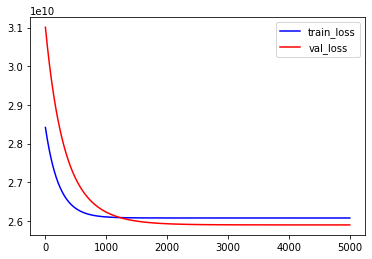

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(ScratchLR_noBias.loss)), ScratchLR_noBias.loss, color='blue', label='train_loss')
plt.plot(range(len(ScratchLR_noBias.val_loss)), ScratchLR_noBias.val_loss, color='red', label='val_loss')
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("lernning curve")
plt.legend()
plt.show()

バイアス項が無いということは、切片が0の為、分類するための1次直線が常に原点（0,0）を通らなくてはならなくなり、分類精度が落ちる。  
そのため、バイアス項ありの場合と比べて、誤差が大きくなっている。  
検証データで、iter = 2000の時 loss = 2.6e+10で収束し、それ以上は学習が進まない。

## 【問題9】（アドバンス課題）特徴量の多次元化

### （２乗化）

In [30]:
ScratchLR_square = ScratchLinearRegression(num_iter = 5000, lr = 0.002, no_bias = False, verbose = True)

ScratchLR_square.fit(np.square(ss_X_train), y_train, np.square(ss_X_val), y_val)

〇〇〇学習データ1回目：loss = 28415447753.401997
★★★検証データ1回目：loss = 30689162159.568565
〇〇〇学習データ2回目：loss = 28063463254.241135
★★★検証データ2回目：loss = 30362422597.5955
〇〇〇学習データ3回目：loss = 27723047242.729305
★★★検証データ3回目：loss = 30043532444.329773
〇〇〇学習データ4回目：loss = 27393721054.8293
★★★検証データ4回目：loss = 29732247869.791737
〇〇〇学習データ5回目：loss = 27075027029.860706
★★★検証データ5回目：loss = 29428333704.4079
〇〇〇学習データ6回目：loss = 26766527574.421535
★★★検証データ6回目：loss = 29131563104.81747
〇〇〇学習データ7回目：loss = 26467804268.202053
★★★検証データ7回目：loss = 28841717233.2848
〇〇〇学習データ8回目：loss = 26178457009.81432
★★★検証データ8回目：loss = 28558584950.144073
〇〇〇学習データ9回目：loss = 25898103200.84441
★★★検証データ9回目：loss = 28281962518.72744
〇〇〇学習データ10回目：loss = 25626376966.414963
★★★検証データ10回目：loss = 28011653322.251335
〇〇〇学習データ11回目：loss = 25362928410.62242
★★★検証データ11回目：loss = 27747467592.15843
〇〇〇学習データ12回目：loss = 25107422905.286583
★★★検証データ12回目：loss = 27489222147.434227
〇〇〇学習データ13回目：loss = 24859540410.520042
★★★検証データ13回目：loss = 27236740144.438053
〇〇〇学習データ14回目：loss 

★★★検証データ354回目：loss = 9774371419.093527
〇〇〇学習データ355回目：loss = 9250453846.43182
★★★検証データ355回目：loss = 9761265366.685379
〇〇〇学習データ356回目：loss = 9237809406.069504
★★★検証データ356回目：loss = 9748201929.84749
〇〇〇学習データ357回目：loss = 9225206242.120192
★★★検証データ357回目：loss = 9735180844.199818
〇〇〇学習データ358回目：loss = 9212644102.734695
★★★検証データ358回目：loss = 9722201848.031836
〇〇〇学習データ359回目：loss = 9200122738.531893
★★★検証データ359回目：loss = 9709264682.269299
〇〇〇学習データ360回目：loss = 9187641902.570543
★★★検証データ360回目：loss = 9696369090.441473
〇〇〇学習データ361回目：loss = 9175201350.321417
★★★検証データ361回目：loss = 9683514818.648834
〇〇〇学習データ362回目：loss = 9162800839.639788
★★★検証データ362回目：loss = 9670701615.531216
〇〇〇学習データ363回目：loss = 9150440130.73821
★★★検証データ363回目：loss = 9657929232.236422
〇〇〇学習データ364回目：loss = 9138118986.159672
★★★検証データ364回目：loss = 9645197422.38926
〇〇〇学習データ365回目：loss = 9125837170.751009
★★★検証データ365回目：loss = 9632505942.06103
〇〇〇学習データ366回目：loss = 9113594451.636683
★★★検証データ366回目：loss = 9619854549.739428
〇〇〇学習データ367回目：loss = 910139059

〇〇〇学習データ802回目：loss = 5925416622.085453
★★★検証データ802回目：loss = 6293651774.094457
〇〇〇学習データ803回目：loss = 5921187089.429407
★★★検証データ803回目：loss = 6289137473.395011
〇〇〇学習データ804回目：loss = 5916966872.2223215
★★★検証データ804回目：loss = 6284632530.671818
〇〇〇学習データ805回目：loss = 5912755949.311284
★★★検証データ805回目：loss = 6280136924.780256
〇〇〇学習データ806回目：loss = 5908554299.598919
★★★検証データ806回目：loss = 6275650634.634338
〇〇〇学習データ807回目：loss = 5904361902.043124
★★★検証データ807回目：loss = 6271173639.206442
〇〇〇学習データ808回目：loss = 5900178735.656863
★★★検証データ808回目：loss = 6266705917.527067
〇〇〇学習データ809回目：loss = 5896004779.507929
★★★検証データ809回目：loss = 6262247448.68457
〇〇〇学習データ810回目：loss = 5891840012.718717
★★★検証データ810回目：loss = 6257798211.824911
〇〇〇学習データ811回目：loss = 5887684414.466006
★★★検証データ811回目：loss = 6253358186.151405
〇〇〇学習データ812回目：loss = 5883537963.98073
★★★検証データ812回目：loss = 6248927350.924477
〇〇〇学習データ813回目：loss = 5879400640.547767
★★★検証データ813回目：loss = 6244505685.461403
〇〇〇学習データ814回目：loss = 5875272423.505707
★★★検証データ814回目：loss = 62400

〇〇〇学習データ1197回目：loss = 4807133113.378148
★★★検証データ1197回目：loss = 5067856514.109069
〇〇〇学習データ1198回目：loss = 4805354666.580775
★★★検証データ1198回目：loss = 5065824226.261197
〇〇〇学習データ1199回目：loss = 4803580109.673203
★★★検証データ1199回目：loss = 5063795948.904228
〇〇〇学習データ1200回目：loss = 4801809434.141584
★★★検証データ1200回目：loss = 5061771673.694135
〇〇〇学習データ1201回目：loss = 4800042631.490775
★★★検証データ1201回目：loss = 5059751392.305023
〇〇〇学習データ1202回目：loss = 4798279693.244291
★★★検証データ1202回目：loss = 5057735096.429082
〇〇〇学習データ1203回目：loss = 4796520610.944268
★★★検証データ1203回目：loss = 5055722777.776554
〇〇〇学習データ1204回目：loss = 4794765376.151415
★★★検証データ1204回目：loss = 5053714428.075685
〇〇〇学習データ1205回目：loss = 4793013980.444982
★★★検証データ1205回目：loss = 5051710039.0726795
〇〇〇学習データ1206回目：loss = 4791266415.422708
★★★検証データ1206回目：loss = 5049709602.531666
〇〇〇学習データ1207回目：loss = 4789522672.700784
★★★検証データ1207回目：loss = 5047713110.234659
〇〇〇学習データ1208回目：loss = 4787782743.913818
★★★検証データ1208回目：loss = 5045720553.981501
〇〇〇学習データ1209回目：loss = 4786046620.714783

★★★検証データ1609回目：loss = 4491562607.371726
〇〇〇学習データ1610回目：loss = 4323172741.732074
★★★検証データ1610回目：loss = 4490645045.831907
〇〇〇学習データ1611回目：loss = 4322452720.848875
★★★検証データ1611回目：loss = 4489729209.766888
〇〇〇学習データ1612回目：loss = 4321734274.588725
★★★検証データ1612回目：loss = 4488815095.707975
〇〇〇学習データ1613回目：loss = 4321017399.508021
★★★検証データ1613回目：loss = 4487902700.1937475
〇〇〇学習データ1614回目：loss = 4320302092.17069
★★★検証データ1614回目：loss = 4486992019.770041
〇〇〇学習データ1615回目：loss = 4319588349.1481695
★★★検証データ1615回目：loss = 4486083050.989931
〇〇〇学習データ1616回目：loss = 4318876167.0194025
★★★検証データ1616回目：loss = 4485175790.4137125
〇〇〇学習データ1617回目：loss = 4318165542.37081
★★★検証データ1617回目：loss = 4484270234.608893
〇〇〇学習データ1618回目：loss = 4317456471.79628
★★★検証データ1618回目：loss = 4483366380.150174
〇〇〇学習データ1619回目：loss = 4316748951.897147
★★★検証データ1619回目：loss = 4482464223.619429
〇〇〇学習データ1620回目：loss = 4316042979.282186
★★★検証データ1620回目：loss = 4481563761.6057
〇〇〇学習データ1621回目：loss = 4315338550.567579
★★★検証データ1621回目：loss = 4480664990.70517
〇〇

★★★検証データ2000回目：loss = 4236018060.3362765
〇〇〇学習データ2001回目：loss = 4133809781.3786726
★★★検証データ2001回目：loss = 4235569781.0445104
〇〇〇学習データ2002回目：loss = 4133503880.050297
★★★検証データ2002回目：loss = 4235122298.546388
〇〇〇学習データ2003回目：loss = 4133198647.699737
★★★検証データ2003回目：loss = 4234675611.299995
〇〇〇学習データ2004回目：loss = 4132894082.8640027
★★★検証データ2004回目：loss = 4234229717.7665644
〇〇〇学習データ2005回目：loss = 4132590184.0832996
★★★検証データ2005回目：loss = 4233784616.410477
〇〇〇学習データ2006回目：loss = 4132286949.9010267
★★★検証データ2006回目：loss = 4233340305.699259
〇〇〇学習データ2007回目：loss = 4131984378.8637686
★★★検証データ2007回目：loss = 4232896784.103564
〇〇〇学習データ2008回目：loss = 4131682469.521288
★★★検証データ2008回目：loss = 4232454050.097177
〇〇〇学習データ2009回目：loss = 4131381220.4265194
★★★検証データ2009回目：loss = 4232012102.157005
〇〇〇学習データ2010回目：loss = 4131080630.135563
★★★検証データ2010回目：loss = 4231570938.763064
〇〇〇学習データ2011回目：loss = 4130780697.2076745
★★★検証データ2011回目：loss = 4231130558.3984833
〇〇〇学習データ2012回目：loss = 4130481420.2052627
★★★検証データ2012回目：loss = 423069

★★★検証データ2405回目：loss = 4105673506.192728
〇〇〇学習データ2406回目：loss = 4051564939.067243
★★★検証データ2406回目：loss = 4105450190.346432
〇〇〇学習データ2407回目：loss = 4051438899.5691338
★★★検証データ2407回目：loss = 4105227245.0270963
〇〇〇学習データ2408回目：loss = 4051313135.7076926
★★★検証データ2408回目：loss = 4105004669.553326
〇〇〇学習データ2409回目：loss = 4051187646.8801303
★★★検証データ2409回目：loss = 4104782463.2450733
〇〇〇学習データ2410回目：loss = 4051062432.484973
★★★検証データ2410回目：loss = 4104560625.4236364
〇〇〇学習データ2411回目：loss = 4050937491.9220595
★★★検証データ2411回目：loss = 4104339155.411657
〇〇〇学習データ2412回目：loss = 4050812824.5925465
★★★検証データ2412回目：loss = 4104118052.533117
〇〇〇学習データ2413回目：loss = 4050688429.898899
★★★検証データ2413回目：loss = 4103897316.1133394
〇〇〇学習データ2414回目：loss = 4050564307.2448864
★★★検証データ2414回目：loss = 4103676945.47898
〇〇〇学習データ2415回目：loss = 4050440456.0355825
★★★検証データ2415回目：loss = 4103456939.958028
〇〇〇学習データ2416回目：loss = 4050316875.6773643
★★★検証データ2416回目：loss = 4103237298.879801
〇〇〇学習データ2417回目：loss = 4050193565.5779057
★★★検証データ2417回目：loss = 410301

★★★検証データ2793回目：loss = 4041342044.7479653
〇〇〇学習データ2794回目：loss = 4018578329.5153093
★★★検証データ2794回目：loss = 4041222141.0540466
〇〇〇学習データ2795回目：loss = 4018524428.666774
★★★検証データ2795回目：loss = 4041102422.512448
〇〇〇学習データ2796回目：loss = 4018470645.694385
★★★検証データ2796回目：loss = 4040982888.8025703
〇〇〇学習データ2797回目：loss = 4018416980.34036
★★★検証データ2797回目：loss = 4040863539.6044235
〇〇〇学習データ2798回目：loss = 4018363432.347475
★★★検証データ2798回目：loss = 4040744374.5986276
〇〇〇学習データ2799回目：loss = 4018310001.4590755
★★★検証データ2799回目：loss = 4040625393.4664063
〇〇〇学習データ2800回目：loss = 4018256687.4190626
★★★検証データ2800回目：loss = 4040506595.88959
〇〇〇学習データ2801回目：loss = 4018203489.971901
★★★検証データ2801回目：loss = 4040387981.550613
〇〇〇学習データ2802回目：loss = 4018150408.862613
★★★検証データ2802回目：loss = 4040269550.132511
〇〇〇学習データ2803回目：loss = 4018097443.8367767
★★★検証データ2803回目：loss = 4040151301.318922
〇〇〇学習データ2804回目：loss = 4018044594.6405306
★★★検証データ2804回目：loss = 4040033234.7940855
〇〇〇学習データ2805回目：loss = 4017991861.0205655
★★★検証データ2805回目：loss = 4039915

★★★検証データ3181回目：loss = 4006112054.454064
〇〇〇学習データ3182回目：loss = 4004471590.976026
★★★検証データ3182回目：loss = 4006044819.3741393
〇〇〇学習データ3183回目：loss = 4004448540.253696
★★★検証データ3183回目：loss = 4005977680.933678
〇〇〇学習データ3184回目：loss = 4004425539.9411535
★★★検証データ3184回目：loss = 4005910638.9764752
〇〇〇学習データ3185回目：loss = 4004402589.928157
★★★検証データ3185回目：loss = 4005843693.3466077
〇〇〇学習データ3186回目：loss = 4004379690.104707
★★★検証データ3186回目：loss = 4005776843.888435
〇〇〇学習データ3187回目：loss = 4004356840.3610415
★★★検証データ3187回目：loss = 4005710090.4465914
〇〇〇学習データ3188回目：loss = 4004334040.587642
★★★検証データ3188回目：loss = 4005643432.865999
〇〇〇学習データ3189回目：loss = 4004311290.6752286
★★★検証データ3189回目：loss = 4005576870.991852
〇〇〇学習データ3190回目：loss = 4004288590.514759
★★★検証データ3190回目：loss = 4005510404.669624
〇〇〇学習データ3191回目：loss = 4004265939.9974313
★★★検証データ3191回目：loss = 4005444033.745072
〇〇〇学習データ3192回目：loss = 4004243339.0146804
★★★検証データ3192回目：loss = 4005377758.064224
〇〇〇学習データ3193回目：loss = 4004220787.4581776
★★★検証データ3193回目：loss = 40053115

★★★検証データ3565回目：loss = 3986155610.6227274
〇〇〇学習データ3566回目：loss = 3998478484.9713335
★★★検証データ3566回目：loss = 3986116209.849663
〇〇〇学習データ3567回目：loss = 3998468540.614879
★★★検証データ3567回目：loss = 3986076862.140408
〇〇〇学習データ3568回目：loss = 3998458618.005808
★★★検証データ3568回目：loss = 3986037567.415136
〇〇〇学習データ3569回目：loss = 3998448717.0965605
★★★検証データ3569回目：loss = 3985998325.5941463
〇〇〇学習データ3570回目：loss = 3998438837.8396816
★★★検証データ3570回目：loss = 3985959136.597883
〇〇〇学習データ3571回目：loss = 3998428980.187819
★★★検証データ3571回目：loss = 3985920000.3469195
〇〇〇学習データ3572回目：loss = 3998419144.093725
★★★検証データ3572回目：loss = 3985880916.761961
〇〇〇学習データ3573回目：loss = 3998409329.5102563
★★★検証データ3573回目：loss = 3985841885.7638516
〇〇〇学習データ3574回目：loss = 3998399536.390368
★★★検証データ3574回目：loss = 3985802907.2735662
〇〇〇学習データ3575回目：loss = 3998389764.6871233
★★★検証データ3575回目：loss = 3985763981.212215
〇〇〇学習データ3576回目：loss = 3998380014.353685
★★★検証データ3576回目：loss = 3985725107.501039
〇〇〇学習データ3577回目：loss = 3998370285.34332
★★★検証データ3577回目：loss = 398568628

★★★検証データ3877回目：loss = 3976083621.1917815
〇〇〇学習データ3878回目：loss = 3996227918.3392706
★★★検証データ3878回目：loss = 3976057493.1983213
〇〇〇学習データ3879回目：loss = 3996222895.7628884
★★★検証データ3879回目：loss = 3976031398.819366
〇〇〇学習データ3880回目：loss = 3996217884.1704144
★★★検証データ3880回目：loss = 3976005338.00714
〇〇〇学習データ3881回目：loss = 3996212883.5378265
★★★検証データ3881回目：loss = 3975979310.7139473
〇〇〇学習データ3882回目：loss = 3996207893.841159
★★★検証データ3882回目：loss = 3975953316.892164
〇〇〇学習データ3883回目：loss = 3996202915.0564933
★★★検証データ3883回目：loss = 3975927356.4942474
〇〇〇学習データ3884回目：loss = 3996197947.1599665
★★★検証データ3884回目：loss = 3975901429.4727244
〇〇〇学習データ3885回目：loss = 3996192990.127769
★★★検証データ3885回目：loss = 3975875535.780203
〇〇〇学習データ3886回目：loss = 3996188043.936139
★★★検証データ3886回目：loss = 3975849675.3693643
〇〇〇学習データ3887回目：loss = 3996183108.5613713
★★★検証データ3887回目：loss = 3975823848.1929655
〇〇〇学習データ3888回目：loss = 3996178183.9798098
★★★検証データ3888回目：loss = 3975798054.203839
〇〇〇学習データ3889回目：loss = 3996173270.1678486
★★★検証データ3889回目：loss = 397

★★★検証データ4193回目：loss = 3969279267.5426273
〇〇〇学習データ4194回目：loss = 3995081115.382667
★★★検証データ4194回目：loss = 3969261732.1631317
〇〇〇学習データ4195回目：loss = 3995078600.757776
★★★検証データ4195回目：loss = 3969244218.486154
〇〇〇学習データ4196回目：loss = 3995076091.6321344
★★★検証データ4196回目：loss = 3969226726.4824452
〇〇〇学習データ4197回目：loss = 3995073587.993718
★★★検証データ4197回目：loss = 3969209256.1227994
〇〇〇学習データ4198回目：loss = 3995071089.8305273
★★★検証データ4198回目：loss = 3969191807.378053
〇〇〇学習データ4199回目：loss = 3995068597.1305857
★★★検証データ4199回目：loss = 3969174380.219089
〇〇〇学習データ4200回目：loss = 3995066109.8819475
★★★検証データ4200回目：loss = 3969156974.616832
〇〇〇学習データ4201回目：loss = 3995063628.0726924
★★★検証データ4201回目：loss = 3969139590.542251
〇〇〇学習データ4202回目：loss = 3995061151.690922
★★★検証データ4202回目：loss = 3969122227.966362
〇〇〇学習データ4203回目：loss = 3995058680.724769
★★★検証データ4203回目：loss = 3969104886.860219
〇〇〇学習データ4204回目：loss = 3995056215.1623893
★★★検証データ4204回目：loss = 3969087567.1949224
〇〇〇学習データ4205回目：loss = 3995053754.9919653
★★★検証データ4205回目：loss = 396907

〇〇〇学習データ4577回目：loss = 3994428409.051389
★★★検証データ4577回目：loss = 3963902479.6488185
〇〇〇学習データ4578回目：loss = 3994427321.8345866
★★★検証データ4578回目：loss = 3963891481.400299
〇〇〇学習データ4579回目：loss = 3994426236.995425
★★★検証データ4579回目：loss = 3963880496.270689
〇〇〇学習データ4580回目：loss = 3994425154.528707
★★★検証データ4580回目：loss = 3963869524.243259
〇〇〇学習データ4581回目：loss = 3994424074.4292426
★★★検証データ4581回目：loss = 3963858565.3013043
〇〇〇学習データ4582回目：loss = 3994422996.691855
★★★検証データ4582回目：loss = 3963847619.428144
〇〇〇学習データ4583回目：loss = 3994421921.3113794
★★★検証データ4583回目：loss = 3963836686.6071205
〇〇〇学習データ4584回目：loss = 3994420848.28266
★★★検証データ4584回目：loss = 3963825766.8215976
〇〇〇学習データ4585回目：loss = 3994419777.6005564
★★★検証データ4585回目：loss = 3963814860.054965
〇〇〇学習データ4586回目：loss = 3994418709.259934
★★★検証データ4586回目：loss = 3963803966.290635
〇〇〇学習データ4587回目：loss = 3994417643.255674
★★★検証データ4587回目：loss = 3963793085.512043
〇〇〇学習データ4588回目：loss = 3994416579.582665
★★★検証データ4588回目：loss = 3963782217.7026467
〇〇〇学習データ4589回目：loss = 3994415518

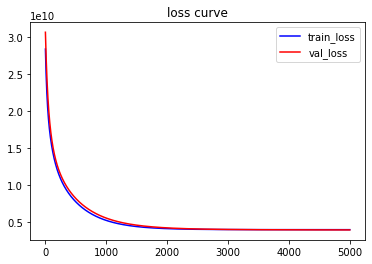

In [31]:
plt.plot(range(len(ScratchLR_square.loss)), ScratchLR_square.loss, color='blue', label='train_loss')
plt.plot(range(len(ScratchLR_square.val_loss)), ScratchLR_square.val_loss, color='red', label='val_loss')
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("lernning curve")
plt.legend()
plt.show()

検証データでiter = 2000 でloss = 0.5e+10で収束している。  
元データに対して収束するiter回数が長くかかっている。

### (３乗化)

In [32]:
ScratchLR_Cube = ScratchLinearRegression(num_iter = 5000, lr = 0.002, no_bias = False, verbose = True)

ScratchLR_Cube.fit(ss_X_train**3, y_train, ss_X_val**3, y_val)

〇〇〇学習データ1回目：loss = 28415701398.90684
★★★検証データ1回目：loss = 30320220340.239666
〇〇〇学習データ2回目：loss = 27570814839.52516
★★★検証データ2回目：loss = 30038545004.697754
〇〇〇学習データ3回目：loss = 27384165319.259098
★★★検証データ3回目：loss = 29876116516.85452
〇〇〇学習データ4回目：loss = 27259004920.859814
★★★検証データ4回目：loss = 29749802075.34917
〇〇〇学習データ5回目：loss = 27141560549.108913
★★★検証データ5回目：loss = 29635391394.798107
〇〇〇学習データ6回目：loss = 27026878041.271072
★★★検証データ6回目：loss = 29525654819.67031
〇〇〇学習データ7回目：loss = 26914399326.230953
★★★検証データ7回目：loss = 29418379922.812935
〇〇〇学習データ8回目：loss = 26803968544.643906
★★★検証データ8回目：loss = 29312850689.26156
〇〇〇学習データ9回目：loss = 26695472576.073647
★★★検証データ9回目：loss = 29208800913.553013
〇〇〇学習データ10回目：loss = 26588808310.339344
★★★検証データ10回目：loss = 29106101969.96052
〇〇〇学習データ11回目：loss = 26483879317.678978
★★★検証データ11回目：loss = 29004669427.480335
〇〇〇学習データ12回目：loss = 26380595186.11159
★★★検証データ12回目：loss = 28904434973.49033
〇〇〇学習データ13回目：loss = 26278871121.41589
★★★検証データ13回目：loss = 28805337844.675034
〇〇〇学習データ14回目：l

〇〇〇学習データ455回目：loss = 8151258753.540234
★★★検証データ455回目：loss = 9245522590.762762
〇〇〇学習データ456回目：loss = 8135620563.07809
★★★検証データ456回目：loss = 9227633680.27561
〇〇〇学習データ457回目：loss = 8120041251.23799
★★★検証データ457回目：loss = 9209808101.099043
〇〇〇学習データ458回目：loss = 8104520596.338783
★★★検証データ458回目：loss = 9192045622.366674
〇〇〇学習データ459回目：loss = 8089058377.533953
★★★検証データ459回目：loss = 9174346014.067007
〇〇〇学習データ460回目：loss = 8073654374.808484
★★★検証データ460回目：loss = 9156709047.040232
〇〇〇学習データ461回目：loss = 8058308368.975731
★★★検証データ461回目：loss = 9139134492.975054
〇〇〇学習データ462回目：loss = 8043020141.674296
★★★検証データ462回目：loss = 9121622124.40553
〇〇〇学習データ463回目：loss = 8027789475.364921
★★★検証データ463回目：loss = 9104171714.70792
〇〇〇学習データ464回目：loss = 8012616153.3274
★★★検証データ464回目：loss = 9086783038.097525
〇〇〇学習データ465回目：loss = 7997499959.657486
★★★検証データ465回目：loss = 9069455869.625572
〇〇〇学習データ466回目：loss = 7982440679.263826
★★★検証データ466回目：loss = 9052189985.176096
〇〇〇学習データ467回目：loss = 7967438097.864897
★★★検証データ467回目：loss = 9034985161.

★★★検証データ827回目：loss = 5518242049.461471
〇〇〇学習データ828回目：loss = 5014830746.272961
★★★検証データ828回目：loss = 5513310481.843087
〇〇〇学習データ829回目：loss = 5011001374.718862
★★★検証データ829回目：loss = 5508395488.142287
〇〇〇学習データ830回目：loss = 5007186420.95312
★★★検証データ830回目：loss = 5503497009.714116
〇〇〇学習データ831回目：loss = 5003385830.691998
★★★検証データ831回目：loss = 5498614988.1273365
〇〇〇学習データ832回目：loss = 4999599549.856128
★★★検証データ832回目：loss = 5493749365.16365
〇〇〇学習データ833回目：loss = 4995827524.569764
★★★検証データ833回目：loss = 5488900082.816895
〇〇〇学習データ834回目：loss = 4992069701.159999
★★★検証データ834回目：loss = 5484067083.292272
〇〇〇学習データ835回目：loss = 4988326026.156011
★★★検証データ835回目：loss = 5479250309.005551
〇〇〇学習データ836回目：loss = 4984596446.288296
★★★検証データ836回目：loss = 5474449702.582304
〇〇〇学習データ837回目：loss = 4980880908.487912
★★★検証データ837回目：loss = 5469665206.857117
〇〇〇学習データ838回目：loss = 4977179359.885728
★★★検証データ838回目：loss = 5464896764.87282
〇〇〇学習データ839回目：loss = 4973491747.811666
★★★検証データ839回目：loss = 5460144319.879722
〇〇〇学習データ840回目：loss = 496981

〇〇〇学習データ1222回目：loss = 4227836140.972142
★★★検証データ1222回目：loss = 4426211061.278312
〇〇〇学習データ1223回目：loss = 4226969846.126345
★★★検証データ1223回目：loss = 4424835287.184962
〇〇〇学習データ1224回目：loss = 4226106812.926895
★★★検証データ1224回目：loss = 4423463746.479134
〇〇〇学習データ1225回目：loss = 4225247029.093521
★★★検証データ1225回目：loss = 4422096425.00534
〇〇〇学習データ1226回目：loss = 4224390482.3921847
★★★検証データ1226回目：loss = 4420733308.658033
〇〇〇学習データ1227回目：loss = 4223537160.634912
★★★検証データ1227回目：loss = 4419374383.381419
〇〇〇学習データ1228回目：loss = 4222687051.6796165
★★★検証データ1228回目：loss = 4418019635.169274
〇〇〇学習データ1229回目：loss = 4221840143.429926
★★★検証データ1229回目：loss = 4416669050.064771
〇〇〇学習データ1230回目：loss = 4220996423.8350143
★★★検証データ1230回目：loss = 4415322614.16029
〇〇〇学習データ1231回目：loss = 4220155880.889425
★★★検証データ1231回目：loss = 4413980313.597251
〇〇〇学習データ1232回目：loss = 4219318502.6329055
★★★検証データ1232回目：loss = 4412642134.565926
〇〇〇学習データ1233回目：loss = 4218484277.150231
★★★検証データ1233回目：loss = 4411308063.305264
〇〇〇学習データ1234回目：loss = 4217653192.57103

〇〇〇学習データ1671回目：loss = 4040046829.1440897
★★★検証データ1671回目：loss = 4084509010.4493823
〇〇〇学習データ1672回目：loss = 4039887571.083803
★★★検証データ1672回目：loss = 4084132833.6249814
〇〇〇学習データ1673回目：loss = 4039728912.638616
★★★検証データ1673回目：loss = 4083757667.3122706
〇〇〇学習データ1674回目：loss = 4039570851.5509467
★★★検証データ1674回目：loss = 4083383508.471295
〇〇〇学習データ1675回目：loss = 4039413385.5717115
★★★検証データ1675回目：loss = 4083010354.072104
〇〇〇学習データ1676回目：loss = 4039256512.460295
★★★検証データ1676回目：loss = 4082638201.0947194
〇〇〇学習データ1677回目：loss = 4039100229.9845195
★★★検証データ1677回目：loss = 4082267046.5290976
〇〇〇学習データ1678回目：loss = 4038944535.9206095
★★★検証データ1678回目：loss = 4081896887.3750916
〇〇〇学習データ1679回目：loss = 4038789428.0531635
★★★検証データ1679回目：loss = 4081527720.642425
〇〇〇学習データ1680回目：loss = 4038634904.1751184
★★★検証データ1680回目：loss = 4081159543.3506494
〇〇〇学習データ1681回目：loss = 4038480962.0877256
★★★検証データ1681回目：loss = 4080792352.529113
〇〇〇学習データ1682回目：loss = 4038327599.600511
★★★検証データ1682回目：loss = 4080426145.216929
〇〇〇学習データ1683回目：loss = 403

〇〇〇学習データ2035回目：loss = 4008463382.9730997
★★★検証データ2035回目：loss = 3995822920.49655
〇〇〇学習データ2036回目：loss = 4008423038.273955
★★★検証データ2036回目：loss = 3995673683.254122
〇〇〇学習データ2037回目：loss = 4008382845.4747562
★★★検証データ2037回目：loss = 3995524803.644287
〇〇〇学習データ2038回目：loss = 4008342804.003594
★★★検証データ2038回目：loss = 3995376280.7054157
〇〇〇学習データ2039回目：loss = 4008302913.290707
★★★検証データ2039回目：loss = 3995228113.4787703
〇〇〇学習データ2040回目：loss = 4008263172.768484
★★★検証データ2040回目：loss = 3995080301.008504
〇〇〇学習データ2041回目：loss = 4008223581.8714504
★★★検証データ2041回目：loss = 3994932842.341643
〇〇〇学習データ2042回目：loss = 4008184140.036257
★★★検証データ2042回目：loss = 3994785736.528083
〇〇〇学習データ2043回目：loss = 4008144846.7016783
★★★検証データ2043回目：loss = 3994638982.6205735
〇〇〇学習データ2044回目：loss = 4008105701.3086033
★★★検証データ2044回目：loss = 3994492579.674714
〇〇〇学習データ2045回目：loss = 4008066703.300023
★★★検証データ2045回目：loss = 3994346526.7489448
〇〇〇学習データ2046回目：loss = 4008027852.1210265
★★★検証データ2046回目：loss = 3994200822.9045315
〇〇〇学習データ2047回目：loss = 40079891

★★★検証データ2477回目：loss = 3954472508.4863496
〇〇〇学習データ2478回目：loss = 3999762836.210692
★★★検証データ2478回目：loss = 3954417654.8406444
〇〇〇学習データ2479回目：loss = 3999755249.534649
★★★検証データ2479回目：loss = 3954362918.981451
〇〇〇学習データ2480回目：loss = 3999747691.4228454
★★★検証データ2480回目：loss = 3954308300.6325107
〇〇〇学習データ2481回目：loss = 3999740161.767737
★★★検証データ2481回目：loss = 3954253799.51829
〇〇〇学習データ2482回目：loss = 3999732660.462183
★★★検証データ2482回目：loss = 3954199415.3639765
〇〇〇学習データ2483回目：loss = 3999725187.399443
★★★検証データ2483回目：loss = 3954145147.8954825
〇〇〇学習データ2484回目：loss = 3999717742.473186
★★★検証データ2484回目：loss = 3954090996.8394356
〇〇〇学習データ2485回目：loss = 3999710325.5774713
★★★検証データ2485回目：loss = 3954036961.92318
〇〇〇学習データ2486回目：loss = 3999702936.6067667
★★★検証データ2486回目：loss = 3953983042.8747764
〇〇〇学習データ2487回目：loss = 3999695575.45593
★★★検証データ2487回目：loss = 3953929239.422997
〇〇〇学習データ2488回目：loss = 3999688242.0202193
★★★検証データ2488回目：loss = 3953875551.2973228
〇〇〇学習データ2489回目：loss = 3999680936.1952868
★★★検証データ2489回目：loss = 39538219

〇〇〇学習データ2835回目：loss = 3998271934.191086
★★★検証データ2835回目：loss = 3940669576.294312
〇〇〇学習データ2836回目：loss = 3998269960.8407493
★★★検証データ2836回目：loss = 3940643570.167696
〇〇〇学習データ2837回目：loss = 3998267994.9201818
★★★検証データ2837回目：loss = 3940617616.782573
〇〇〇学習データ2838回目：loss = 3998266036.40141
★★★検証データ2838回目：loss = 3940591716.02549
〇〇〇学習データ2839回目：loss = 3998264085.2565665
★★★検証データ2839回目：loss = 3940565867.7832575
〇〇〇学習データ2840回目：loss = 3998262141.457887
★★★検証データ2840回目：loss = 3940540071.9429526
〇〇〇学習データ2841回目：loss = 3998260204.977714
★★★検証データ2841回目：loss = 3940514328.3919206
〇〇〇学習データ2842回目：loss = 3998258275.7884917
★★★検証データ2842回目：loss = 3940488637.017767
〇〇〇学習データ2843回目：loss = 3998256353.8627696
★★★検証データ2843回目：loss = 3940462997.7083654
〇〇〇学習データ2844回目：loss = 3998254439.173201
★★★検証データ2844回目：loss = 3940437410.35185
〇〇〇学習データ2845回目：loss = 3998252531.69254
★★★検証データ2845回目：loss = 3940411874.8366194
〇〇〇学習データ2846回目：loss = 3998250631.3936467
★★★検証データ2846回目：loss = 3940386391.051331
〇〇〇学習データ2847回目：loss = 3998248738.

★★★検証データ3215回目：loss = 3933745825.9583807
〇〇〇学習データ3216回目：loss = 3997872339.7402015
★★★検証データ3216回目：loss = 3933733622.324585
〇〇〇学習データ3217回目：loss = 3997871870.884307
★★★検証データ3217回目：loss = 3933721442.5776258
〇〇〇学習データ3218回目：loss = 3997871403.793681
★★★検証データ3218回目：loss = 3933709286.6691365
〇〇〇学習データ3219回目：loss = 3997870938.461675
★★★検証データ3219回目：loss = 3933697154.5508556
〇〇〇学習データ3220回目：loss = 3997870474.88167
★★★検証データ3220回目：loss = 3933685046.174622
〇〇〇学習データ3221回目：loss = 3997870013.047068
★★★検証データ3221回目：loss = 3933672961.492383
〇〇〇学習データ3222回目：loss = 3997869552.9512978
★★★検証データ3222回目：loss = 3933660900.4561815
〇〇〇学習データ3223回目：loss = 3997869094.587813
★★★検証データ3223回目：loss = 3933648863.01817
〇〇〇学習データ3224回目：loss = 3997868637.9500914
★★★検証データ3224回目：loss = 3933636849.1306
〇〇〇学習データ3225回目：loss = 3997868183.0316343
★★★検証データ3225回目：loss = 3933624858.7458286
〇〇〇学習データ3226回目：loss = 3997867729.8259697
★★★検証データ3226回目：loss = 3933612891.816308
〇〇〇学習データ3227回目：loss = 3997867278.326649
★★★検証データ3227回目：loss = 3933600948.

〇〇〇学習データ3662回目：loss = 3997770964.9929953
★★★検証データ3662回目：loss = 3930097436.476497
〇〇〇学習データ3663回目：loss = 3997770877.8184376
★★★検証データ3663回目：loss = 3930092300.434948
〇〇〇学習データ3664回目：loss = 3997770790.9720964
★★★検証データ3664回目：loss = 3930087174.236385
〇〇〇学習データ3665回目：loss = 3997770704.4527364
★★★検証データ3665回目：loss = 3930082057.8616405
〇〇〇学習データ3666回目：loss = 3997770618.2591267
★★★検証データ3666回目：loss = 3930076951.291584
〇〇〇学習データ3667回目：loss = 3997770532.3900394
★★★検証データ3667回目：loss = 3930071854.507125
〇〇〇学習データ3668回目：loss = 3997770446.8442545
★★★検証データ3668回目：loss = 3930066767.489206
〇〇〇学習データ3669回目：loss = 3997770361.620554
★★★検証データ3669回目：loss = 3930061690.2188144
〇〇〇学習データ3670回目：loss = 3997770276.7177253
★★★検証データ3670回目：loss = 3930056622.6769714
〇〇〇学習データ3671回目：loss = 3997770192.13456
★★★検証データ3671回目：loss = 3930051564.844739
〇〇〇学習データ3672回目：loss = 3997770107.8698554
★★★検証データ3672回目：loss = 3930046516.703215
〇〇〇学習データ3673回目：loss = 3997770023.9224114
★★★検証データ3673回目：loss = 3930041478.2335343
〇〇〇学習データ3674回目：loss = 39977

★★★検証データ4020回目：loss = 3928764843.2926226
〇〇〇学習データ4021回目：loss = 3997753788.5473065
★★★検証データ4021回目：loss = 3928762250.753443
〇〇〇学習データ4022回目：loss = 3997753766.042983
★★★検証データ4022回目：loss = 3928759663.1421814
〇〇〇学習データ4023回目：loss = 3997753743.6233897
★★★検証データ4023回目：loss = 3928757080.449392
〇〇〇学習データ4024回目：loss = 3997753721.2882075
★★★検証データ4024回目：loss = 3928754502.665643
〇〇〇学習データ4025回目：loss = 3997753699.0371184
★★★検証データ4025回目：loss = 3928751929.7815266
〇〇〇学習データ4026回目：loss = 3997753676.869807
★★★検証データ4026回目：loss = 3928749361.787651
〇〇〇学習データ4027回目：loss = 3997753654.785955
★★★検証データ4027回目：loss = 3928746798.674643
〇〇〇学習データ4028回目：loss = 3997753632.7852507
★★★検証データ4028回目：loss = 3928744240.433148
〇〇〇学習データ4029回目：loss = 3997753610.8673797
★★★検証データ4029回目：loss = 3928741687.053828
〇〇〇学習データ4030回目：loss = 3997753589.032031
★★★検証データ4030回目：loss = 3928739138.527364
〇〇〇学習データ4031回目：loss = 3997753567.2788935
★★★検証データ4031回目：loss = 3928736594.8444552
〇〇〇学習データ4032回目：loss = 3997753545.6076584
★★★検証データ4032回目：loss = 392873

〇〇〇学習データ4419回目：loss = 3997749143.3143215
★★★検証データ4419回目：loss = 3928038924.162699
〇〇〇学習データ4420回目：loss = 3997749138.2995486
★★★検証データ4420回目：loss = 3928037708.316593
〇〇〇学習データ4421回目：loss = 3997749133.3036575
★★★検証データ4421回目：loss = 3928036494.7710075
〇〇〇学習データ4422回目：loss = 3997749128.3265753
★★★検証データ4422回目：loss = 3928035283.521572
〇〇〇学習データ4423回目：loss = 3997749123.3682323
★★★検証データ4423回目：loss = 3928034074.5639243
〇〇〇学習データ4424回目：loss = 3997749118.428557
★★★検証データ4424回目：loss = 3928032867.89371
〇〇〇学習データ4425回目：loss = 3997749113.50748
★★★検証データ4425回目：loss = 3928031663.506583
〇〇〇学習データ4426回目：loss = 3997749108.6049314
★★★検証データ4426回目：loss = 3928030461.398209
〇〇〇学習データ4427回目：loss = 3997749103.720842
★★★検証データ4427回目：loss = 3928029261.5642557
〇〇〇学習データ4428回目：loss = 3997749098.85514
★★★検証データ4428回目：loss = 3928028064.0004044
〇〇〇学習データ4429回目：loss = 3997749094.007759
★★★検証データ4429回目：loss = 3928026868.702342
〇〇〇学習データ4430回目：loss = 3997749089.178627
★★★検証データ4430回目：loss = 3928025675.665765
〇〇〇学習データ4431回目：loss = 3997749084.

〇〇〇学習データ4869回目：loss = 3997748055.325181
★★★検証データ4869回目：loss = 3927670249.994557
〇〇〇学習データ4870回目：loss = 3997748054.4067454
★★★検証データ4870回目：loss = 3927669730.902887
〇〇〇学習データ4871回目：loss = 3997748053.4917684
★★★検証データ4871回目：loss = 3927669212.7910824
〇〇〇学習データ4872回目：loss = 3997748052.5802345
★★★検証データ4872回目：loss = 3927668695.65729
〇〇〇学習データ4873回目：loss = 3997748051.6721344
★★★検証データ4873回目：loss = 3927668179.4996605
〇〇〇学習データ4874回目：loss = 3997748050.767453
★★★検証データ4874回目：loss = 3927667664.3163486
〇〇〇学習データ4875回目：loss = 3997748049.8661776
★★★検証データ4875回目：loss = 3927667150.105511
〇〇〇学習データ4876回目：loss = 3997748048.968294
★★★検証データ4876回目：loss = 3927666636.8653092
〇〇〇学習データ4877回目：loss = 3997748048.073793
★★★検証データ4877回目：loss = 3927666124.593908
〇〇〇学習データ4878回目：loss = 3997748047.182659
★★★検証データ4878回目：loss = 3927665613.2894754
〇〇〇学習データ4879回目：loss = 3997748046.2948804
★★★検証データ4879回目：loss = 3927665102.9501824
〇〇〇学習データ4880回目：loss = 3997748045.4104447
★★★検証データ4880回目：loss = 3927664593.5742044
〇〇〇学習データ4881回目：loss = 39977

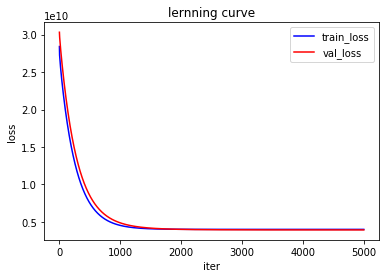

In [33]:
plt.plot(range(len(ScratchLR_Cube.loss)), ScratchLR_Cube.loss, color='blue', label='train_loss')
plt.plot(range(len(ScratchLR_Cube.val_loss)), ScratchLR_Cube.val_loss, color='red', label='val_loss')
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("lernning curve")

plt.legend()
plt.show()

2乗の時と同じように、iter = 1500でloss = 0.5に収束しているが、2乗の時よりも傾きが緩やかになっており、  
学習効率が低下しているのがわかる。